# Seq2Seq with Attention - 영한 번역기
1. 데이터 준비
2. 훈련모델 생성
3. 테스트 모델 생성
4. 테스트, 시각화
5. BLEU Score

폰트 설치

In [ ]:
# 그래프에서 한글표현을 위해 폰트를 설치합니다.
!apt-get update -qq
!apt-get install fonts-nanum* -qq

In [ ]:
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm  # 폰트 관련 용도
path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'  # 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져오자
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)

plt.rc('font', family=font_name)

fm._rebuild()

## 데이터 준비
- 구어체 40만개


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [93]:
import re
import os
import unicodedata
import urllib3
import zipfile
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from konlpy.tag import Okt
from nltk.tokenize import word_tokenize
import nltk
from tqdm.notebook import tqdm

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking, Dropout
from tensorflow.keras.models import Model

### 데이터 다운로드


In [3]:
!gdown --id 1V6HsBoEczDoo4NDZ1I5iXSfRxFxCatis
!gdown --id 10sne6z59Pm-UoLAaLvPyFetTBmDIOIB9

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1V6HsBoEczDoo4NDZ1I5iXSfRxFxCatis
To: /content/1_구어체(1).xlsx
100% 15.8M/15.8M [00:00<00:00, 171MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=10sne6z59Pm-UoLAaLvPyFetTBmDIOIB9
To: /content/1_구어체(2).xlsx
100% 14.3M/14.3M [00:00<00:00, 140MB/s]


In [6]:
df1 = pd.read_excel('/content/1_구어체(1).xlsx')
df2 = pd.read_excel('/content/1_구어체(2).xlsx')
df = pd.concat([df1, df2], ignore_index=True)
df

/usr/local/lib/python3.7/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,SID,원문,번역문
0,1.0,'Bible Coloring'은 성경의 아름다운 이야기를 체험 할 수 있는 컬러링 ...,Bible Coloring' is a coloring application that...
1,2.0,씨티은행에서 일하세요?,Do you work at a City bank?
2,3.0,푸리토의 베스트셀러는 해외에서 입소문만으로 4차 완판을 기록하였다.,"PURITO's bestseller, which recorded 4th rough ..."
3,4.0,11장에서는 예수님이 이번엔 나사로를 무덤에서 불러내어 죽은 자 가운데서 살리셨습니다.,In Chapter 11 Jesus called Lazarus from the to...
4,5.0,"6.5, 7, 8 사이즈가 몇 개나 더 재입고 될지 제게 알려주시면 감사하겠습니다.",I would feel grateful to know how many stocks ...
...,...,...,...
399995,399996.0,당신은 곧 당신의 조카를 볼 수 있어요.,You can see your nephew soon.
399996,399997.0,나는 당신이 내게 공유한 음악을 들었어요.,I've listened to the music that you shared wit...
399997,399998.0,그 서류는 당신이 공유해 준 것과 달라요.,The document is different from what you shared.
399998,399999.0,당신이 잡지에 광고 낸 것을 봤어요.,I saw your advertisement in the magazine.


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   SID     400000 non-null  float64
 1   원문      400000 non-null  object 
 2   번역문     400000 non-null  object 
dtypes: float64(1), object(2)
memory usage: 9.2+ MB


In [84]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
hidden_units = 256  # Latent dimensionality of the encoding space.
embedding_dim = 64
num_samples = 400000  # Number of samples to train on.

### 데이터 전처리 시작
1. 영어 : word_toknize 사용
2. 한글 : okt 사용
3. 각 문장에 start와 end 토큰을 추가합니다.
4. 특정 문자를 제거함으로써 문장을 정리합니다.
5. 단어 인덱스와 아이디(ID) 인덱스를 생성합니다. (단어 → 아이디(ID), 아이디(ID) → 단어로 매핑된 딕셔너리).
6. 각 문장을 입력층의 최대 길이만큼 패딩(padding)을 수행합니다.

In [8]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 541 kB/s 
     |████████████████████████████████| 453 kB 59.8 MB/s 


In [11]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [12]:
def preprocess_sentence_en(sent):

  
  #단어와 구두점 사이에 공백 만들기, 대문자-> 소문자
  sent = re.sub(r"([?.!,¿])", r" \1", sent.lower())

  # (a-z, A-Z, 0-9, 가-힣, ".", "?", "!", ",") 이들을 제외하고는 전부 공백으로 변환합니다.
  sent = re.sub(r"[^a-zA-Z!.?0-9가-힣]+", r" ", sent)

  # 다수 개의 공백을 하나의 공백으로 치환
  sent = re.sub(r"\s+", " ", sent)
  sent = word_tokenize(sent)
  return sent

In [18]:
def preprocess_sentence_kor(sent):

  okt = Okt()
  sent = re.sub(r"([?.!,¿])", r" \1", sent)
  sent = re.sub(r"[^a-zA-Z!.?0-9,가-힣]+", r" ", sent)
  sent = re.sub(r"\s+", " ", sent)
  sent = okt.morphs(sent, stem=False)
  
  return sent

In [19]:
def load_preprocessed_data(df):
  encoder_input, decoder_input, decoder_target = [], [], []


  for idx, row in tqdm(df.iterrows()):
    # source 데이터와 target 데이터 분리
    src_line, tar_line = row[2], row[1]

    # source 데이터 전처리
    src_line = preprocess_sentence_en(src_line)

    # target 데이터 전처리
    tar_line_in = preprocess_sentence_kor(tar_line)
    tar_line_in.insert(0, "<sos>")  # teacher forcing을 위한 정답셋 
    tar_line_out = preprocess_sentence_kor(tar_line)
    tar_line_out.append("<eos>")  

    encoder_input.append(src_line)
    decoder_input.append(tar_line_in)
    decoder_target.append(tar_line_out)

                
  return encoder_input, decoder_input, decoder_target

In [20]:
sents_en_in, sents_kor_in, sents_kor_out  = load_preprocessed_data(df)

0it [00:00, ?it/s]

In [23]:
# sents_en_in_r = []
# for sents in sents_en_in:
#   sents_en_in_r.append(sents[::-1])

In [25]:
# import pickle

# with open('/content/drive/MyDrive/음성인식/pickle_40/sents_en_in.pickle', 'wb') as f:
# 	pickle.dump(sents_en_in, f)
 
# with open('/content/drive/MyDrive/음성인식/pickle_40/sents_kor_in.pickle', 'wb') as f:
# 	pickle.dump(sents_kor_in, f)

# with open('/content/drive/MyDrive/음성인식/pickle_40/sents_kor_out.pickle', 'wb') as f:
# 	pickle.dump(sents_kor_out, f)
 
# with open('/content/drive/MyDrive/음성인식/pickle_40/sents_en_in_r.pickle', 'wb') as f:
# 	pickle.dump(sents_en_in_r, f)

In [ ]:
# !cp /content/sents_en_in.pickle /content/drive/MyDrive/음성인식/pickle
# !cp /content/sents_kor_in.pickle /content/drive/MyDrive/음성인식/pickle
# !cp /content/sents_kor_out.pickle /content/drive/MyDrive/음성인식/pickle

In [ ]:
# import pickle

# with open('/content/drive/MyDrive/음성인식/pickle/sents_en_in.pickle', 'rb') as f:
# 	sents_en_in = pickle.load(f)
 
# with open('/content/drive/MyDrive/음성인식/pickle/sents_kor_in.pickle', 'rb') as f:
# 	sents_kor_in = pickle.load(f)

# with open('/content/drive/MyDrive/음성인식/pickle/sents_kor_out.pickle', 'rb') as f:
# 	sents_kor_out = pickle.load(f)

In [ ]:
print('인코더의 입력 :',sents_en_in[:5])
print('디코더의 입력 :',sents_kor_in[:5])
print('디코더의 레이블 :',sents_kor_out[:5])

인코더의 입력 : [['bible', 'coloring', 'is', 'a', 'coloring', 'application', 'that', 'allows', 'you', 'to', 'experience', 'beautiful', 'stories', 'in', 'the', 'bible', '.'], ['do', 'you', 'work', 'at', 'a', 'city', 'bank', '?'], ['purito', 's', 'bestseller', 'which', 'recorded', '4th', 'rough', 'cuts', 'by', 'words', 'of', 'mouth', 'from', 'abroad', '.'], ['in', 'chapter', '11', 'jesus', 'called', 'lazarus', 'from', 'the', 'tomb', 'and', 'raised', 'him', 'from', 'the', 'dead', '.'], ['i', 'would', 'feel', 'grateful', 'to', 'know', 'how', 'many', 'stocks', 'will', 'be', 'secured', 'of', 'size', '6', '.5', '7', 'and', '8', '.']]
디코더의 입력 : [['<sos>', 'Bible', 'Coloring', '은', '성경', '의', '아름다운', '이야기', '를', '체험', '할', '수', '있는', '컬러링', '앱', '입니다', '.'], ['<sos>', '씨티', '은행', '에서', '일', '하세요', '?'], ['<sos>', '푸리', '토의', '베스트셀러', '는', '해외', '에서', '입', '소문', '만으로', '4', '차', '완판', '을', '기록', '하였다', '.'], ['<sos>', '11', '장', '에서는', '예수님', '이', '이번', '엔', '나사', '로', '를', '무덤', '에서', '불러내어', '죽은', '

In [26]:
len(sents_en_in), len(sents_kor_in), len(sents_kor_out)

(400000, 400000, 400000)

### 단어 집합 생성

In [27]:
# 영어

tokenizer_en = Tokenizer(filters='', lower = False)
tokenizer_en.fit_on_texts(sents_en_in)
encoder_input = tokenizer_en.texts_to_sequences(sents_en_in) # text를 index로 바꿔주는 과정

# tokenizer 설정 -> tokenizer.fit_on_texts -> tokenizer.texts_to_sequences : 전처리한 단어를 인덱스로 바꿔주는 과정

In [28]:
print(encoder_input[:5])
len(encoder_input)

[[3322, 6376, 7, 5, 6376, 747, 14, 1950, 6, 4, 298, 306, 1604, 10, 2, 3322, 1], [35, 6, 76, 33, 5, 413, 547, 12], [4680, 22, 13882, 84, 2701, 2130, 2637, 5994, 44, 455, 9, 1589, 41, 923, 1], [10, 3379, 1435, 2145, 292, 31060, 41, 2, 8492, 8, 2205, 157, 41, 2, 1821, 1], [3, 56, 145, 1818, 4, 55, 63, 94, 3425, 26, 23, 6585, 9, 431, 558, 2375, 738, 8, 874, 1]]


400000

In [30]:
# 한국어
tokenizer_kor = Tokenizer(filters='', lower=False)
tokenizer_kor.fit_on_texts(sents_kor_in)
tokenizer_kor.fit_on_texts(sents_kor_out)

decoder_input = tokenizer_kor.texts_to_sequences(sents_kor_in)
decoder_target = tokenizer_kor.texts_to_sequences(sents_kor_out)

In [31]:
print(decoder_input[:5], '\n' , decoder_target[:5])
len(decoder_input), len(decoder_target)

[[2, 56072, 56073, 9, 4316, 10, 778, 191, 11, 1477, 25, 19, 42, 26271, 882, 23, 1], [2, 11705, 655, 21, 53, 177, 13], [2, 26272, 7235, 13404, 6, 873, 21, 359, 3633, 3202, 360, 329, 34293, 4, 1028, 11706, 1], [2, 2570, 504, 194, 3913, 5, 117, 390, 5381, 27, 11, 6867, 21, 56074, 3503, 238, 2773, 74, 56075, 1], [2, 651, 1, 368, 14, 1001, 14, 1069, 726, 8, 170, 125, 15, 50, 898, 1013, 3321, 37, 75, 2113, 1205, 1]] 
 [[56072, 56073, 9, 4316, 10, 778, 191, 11, 1477, 25, 19, 42, 26271, 882, 23, 1, 3], [11705, 655, 21, 53, 177, 13, 3], [26272, 7235, 13404, 6, 873, 21, 359, 3633, 3202, 360, 329, 34293, 4, 1028, 11706, 1, 3], [2570, 504, 194, 3913, 5, 117, 390, 5381, 27, 11, 6867, 21, 56074, 3503, 238, 2773, 74, 56075, 1, 3], [651, 1, 368, 14, 1001, 14, 1069, 726, 8, 170, 125, 15, 50, 898, 1013, 3321, 37, 75, 2113, 1205, 1, 3]]


(400000, 400000)

In [32]:
src_vocab_size = len(tokenizer_en.word_index) + 1
tar_vocab_size = len(tokenizer_kor.word_index) + 1

print(f"영어 단어 집합의 크기 : {src_vocab_size}, 한국어 단어 집합의 크기 : {tar_vocab_size}")

영어 단어 집합의 크기 : 54786, 한국어 단어 집합의 크기 : 104042


### 단어 집합 살펴보기
- 성능을 저하시킬 수 있다고 판단되는 빈도 수 낮은 희귀 단어 제거
- 영어 :  54785->23977, 한글 : 104041->56072

한글

In [68]:
threshold = 3
total_cnt = len(tokenizer_kor.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer_kor.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %d번 이하인 희귀 단어의 수: %d'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 104041
등장 빈도가 2번 이하인 희귀 단어의 수: 47970
단어 집합에서 희귀 단어의 비율: 46.106823271594855
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.8916728131431495


In [69]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
tar_vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',tar_vocab_size)

단어 집합의 크기 : 56072


In [70]:
# 단어집합의 최대 크기를 제한해서 인덱싱합니다. 

tokenizer_kor = Tokenizer(tar_vocab_size, filters='', lower=False) # 단어 집합의 최대 크기 제한

tokenizer_kor.fit_on_texts(sents_kor_in)
tokenizer_kor.fit_on_texts(sents_kor_out)

decoder_input = tokenizer_kor.texts_to_sequences(sents_kor_in)
decoder_target = tokenizer_kor.texts_to_sequences(sents_kor_out)

word_vocab = tokenizer_kor.word_index # 딕셔너리 형태
print("전체 단어 개수: ", tokenizer_kor.num_words) # 전체 단어 개수 확인

전체 단어 개수:  56072


In [71]:
# 각 샘플들의 길이를 확인해서 길이가 0인 샘플들의 인덱스를 찾으세요. 
drop_train = [index for index, sentence in enumerate(decoder_target) if len(sentence) < 1]

print(len(drop_train))

0


영어

In [72]:
threshold = 3
total_cnt = len(tokenizer_en.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer_en.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %d번 이하인 희귀 단어의 수: %d'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 54785
등장 빈도가 2번 이하인 희귀 단어의 수: 30809
단어 집합에서 희귀 단어의 비율: 56.236196039061795
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.7846011769431779


In [73]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
src_vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',src_vocab_size)

단어 집합의 크기 : 23977


In [74]:
# 단어집합의 최대 크기를 제한해서 인덱싱합니다. 

tokenizer_en = Tokenizer(src_vocab_size, filters='', lower=False) # 단어 집합의 최대 크기 제한

tokenizer_en.fit_on_texts(sents_en_in)
encoder_input = tokenizer_en.texts_to_sequences(sents_en_in)


word_vocab = tokenizer_en.word_index # 딕셔너리 형태
print("전체 단어 개수: ", tokenizer_en.num_words) # 전체 단어 개수 확인

전체 단어 개수:  23977


### 각각 최대길이만큼 패딩

In [75]:
encoder_input = pad_sequences(encoder_input, padding = 'post')
decoder_input = pad_sequences(decoder_input, padding = 'post')
decoder_target = pad_sequences(decoder_target, padding = 'post')

## max_length를 주지 않으면 최대 길이로 패딩 해준다!!

In [76]:
print('인코더의 입력의 크기(shape) :',encoder_input.shape)
print('디코더의 입력의 크기(shape) :',decoder_input.shape)
print('디코더의 레이블의 크기(shape) :',decoder_target.shape)

인코더의 입력의 크기(shape) : (400000, 54)
디코더의 입력의 크기(shape) : (400000, 49)
디코더의 레이블의 크기(shape) : (400000, 49)


In [77]:
print(tokenizer_en.word_index)

{'.': 1, 'the': 2, 'i': 3, 'to': 4, 'a': 5, 'you': 6, 'is': 7, 'and': 8, 'of': 9, 'in': 10, 'it': 11, '?': 12, 'for': 13, 'that': 14, 'my': 15, 'we': 16, 'this': 17, 'have': 18, 'are': 19, 'with': 20, 'can': 21, 's': 22, 'be': 23, 'on': 24, 't': 25, 'will': 26, 'your': 27, 'me': 28, 'was': 29, 'as': 30, 'not': 31, 'if': 32, 'at': 33, 'there': 34, 'do': 35, 'so': 36, 'like': 37, 'but': 38, 'please': 39, 'when': 40, 'from': 41, 'time': 42, 'm': 43, 'by': 44, 'about': 45, 'want': 46, 'an': 47, 'what': 48, 'because': 49, 'he': 50, 'am': 51, 'don': 52, 'go': 53, 'has': 54, 'know': 55, 'would': 56, 'get': 57, 'think': 58, 'after': 59, 'all': 60, 'they': 61, 'our': 62, 'how': 63, 'one': 64, 'or': 65, 'people': 66, 'good': 67, 'who': 68, 'now': 69, 'more': 70, 'up': 71, 'make': 72, 'korea': 73, 'out': 74, 'today': 75, 'work': 76, 'also': 77, 'should': 78, 'going': 79, 'first': 80, 'been': 81, 'let': 82, 'she': 83, 'which': 84, 'take': 85, 'just': 86, 'send': 87, 'day': 88, 'need': 89, 'll': 90

In [78]:
src_to_index = tokenizer_en.word_index  # word : idx
index_to_src = tokenizer_en.index_word  # idx : word
tar_to_index = tokenizer_kor.word_index # word : idx
index_to_tar = tokenizer_kor.index_word # idx : word

###데이터 분할

In [79]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

print('랜덤 시퀀스 :',indices)

랜덤 시퀀스 : [ 90942  43577 191337 ... 314805 194105 306189]


In [80]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

#indices의 index 순서로 바꿔줌

In [81]:
decoder_input[indices[0]], decoder_target[indices[0]]

(array([    2,   457,  1879,     9, 14481,   238,    17,     4,   353,
        18211,   396,   238,    17,     4, 39671,  2056,    61,    45,
            1,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0], dtype=int32),
 array([  457,  1879,     9, 14481,   238,    17,     4,   353, 18211,
          396,   238,    17,     4, 39671,  2056,    61,    45,     1,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0], dtype=int32))

In [85]:
n_of_val = int(num_samples*0.1)

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [86]:
print('훈련 source 데이터의 크기 :',encoder_input_train.shape)
print('훈련 target 데이터의 크기 :',decoder_input_train.shape)
print('훈련 target 레이블의 크기 :',decoder_target_train.shape)
print('테스트 source 데이터의 크기 :',encoder_input_test.shape)
print('테스트 target 데이터의 크기 :',decoder_input_test.shape)
print('테스트 target 레이블의 크기 :',decoder_target_test.shape)

훈련 source 데이터의 크기 : (360000, 54)
훈련 target 데이터의 크기 : (360000, 49)
훈련 target 레이블의 크기 : (360000, 49)
테스트 source 데이터의 크기 : (40000, 54)
테스트 target 데이터의 크기 : (40000, 49)
테스트 target 레이블의 크기 : (40000, 49)


## 훈련 모델 생성
- LSTM(256units, 단층) + Attention

### 인코더

In [88]:
# 인코더
encoder_inputs = Input(shape=(None,))

# 임베딩 층
enc_emb = Embedding(src_vocab_size, hidden_units)(encoder_inputs)

# 상태값 리턴을 위해 return_state는 True
encoder_lstm = LSTM(hidden_units, return_sequences = True, return_state=True)  #객체 설정

# 은닉 상태와 셀 상태를 리턴
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb) 

encoder_states = [state_h, state_c] # 인코더의 은닉 상태와 셀 상태를 저장

### Attention

In [89]:
from keras.layers import AdditiveAttention 

class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
      super().__init__()

      self.units = units
      self.w1 = tf.keras.layers.Dense(units, use_bias = False)
      self.w2 = tf.keras.layers.Dense(units, use_bias = False)

      self.attention = tf.keras.layers.AdditiveAttention()

  def call(self, query, value):
      
      # w1, ht 구현
      w1_query = self.w1(query)
      # w2, hs 구현
      w2_key = self.w2(value)

      # attention 구현
      context_vector, attention_weights = self.attention(inputs = [w1_query, value, w2_key], return_attention_scores = True)

      return context_vector, attention_weights

  def get_config(self):
      config = super().get_config().copy()
      config.update({
          'units': self.units 
      })
      return config



### 디코더

In [90]:
# 디코더
decoder_inputs = Input(shape=(None,))

# 임베딩 층
dec_emb_layer = Embedding(tar_vocab_size, hidden_units)

# 임베딩 결과
dec_emb = dec_emb_layer(decoder_inputs) 

######################
# 상태값 리턴을 위해 return_state는 True, 모든 시점에 대해서 단어를 예측하기 위해 return_sequences는 True
decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True) 
######################

# 인코더의 은닉 상태를 초기 은닉 상태(initial_state)로 사용
decoder_outputs, _ , _ = decoder_lstm(dec_emb,initial_state=encoder_states)

######################
# attention
S_ = tf.concat([state_h[:, tf.newaxis, :], decoder_outputs[:, :-1, :]], axis=1) #state_h는 축이 2개, decoder_outputs은 축이 3개라서 tf.newaxis로 축 추가
# decoder_outputs[:, :-1, :] 에서 -1은 시점을 하나 앞당기는것

attention = BahdanauAttention(hidden_units)
context_vector, _ = attention(S_, encoder_outputs) 

#BahdanauAttention(query=S_, value=encoder_outputs)

concat = tf.concat([decoder_outputs, context_vector], axis=-1)

# 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
decoder_dense = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(concat)

######################

In [91]:
# 모델의 입력과 출력을 정의.
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [92]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 256)    6138112     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 256)    14354432    ['input_2[0][0]']                
                                                                                              

### 학습
- EarlyStopping과 ModelCheckpoint를 callback으로 사용

In [95]:
callbacks = [  
        tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),  
        tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/음성인식/model/model.{epoch:02d}-{val_loss:.2f}.h5', save_best_only=True, verbose=1)
    ]  

In [97]:
model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, 
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=128, epochs=20, callbacks = callbacks)

Epoch 1/20
2813/2813 [==============================] - ETA: 0s - loss: 0.9058 - acc: 0.8394
Epoch 1: val_loss improved from inf to 0.87378, saving model to /content/drive/MyDrive/음성인식/model/model.01-0.87.h5
2813/2813 [==============================] - 1001s 356ms/step - loss: 0.9058 - acc: 0.8394 - val_loss: 0.8738 - val_acc: 0.8432
Epoch 2/20
2813/2813 [==============================] - ETA: 0s - loss: 0.7531 - acc: 0.8509
Epoch 2: val_loss improved from 0.87378 to 0.82286, saving model to /content/drive/MyDrive/음성인식/model/model.02-0.82.h5
2813/2813 [==============================] - 997s 354ms/step - loss: 0.7531 - acc: 0.8509 - val_loss: 0.8229 - val_acc: 0.8477
Epoch 3/20
2813/2813 [==============================] - ETA: 0s - loss: 0.6564 - acc: 0.8601
Epoch 3: val_loss improved from 0.82286 to 0.80581, saving model to /content/drive/MyDrive/음성인식/model/model.03-0.81.h5
2813/2813 [==============================] - 998s 355ms/step - loss: 0.6564 - acc: 0.8601

In [98]:
from keras.models import load_model

model.save('/content/drive/MyDrive/음성인식/model/model_5_24.h5')

## 테스트 모델 생성

### Modeling

In [99]:
# 인코더 - 훈련과 동일 

######################
encoder_model = Model(encoder_inputs, [encoder_outputs, encoder_states])
######################

In [100]:
# 디코더 


# 이전 시점의 상태를 보관할 텐서
decoder_state_input_h = Input(shape=(hidden_units,))
decoder_state_input_c = Input(shape=(hidden_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

###################### attention을 위해
encoder_state_h = Input(shape=(hidden_units,)) # encoder 마지막 h
encoder_outputs2 = Input(shape =(None, hidden_units,)) # encoder 전체시점 h 
######################

# 훈련 때 사용했던 임베딩 층을 재사용
dec_emb2 = dec_emb_layer(decoder_inputs)

# 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
decoder_outputs2, state_h, state_c = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h, state_c]

###################### attention vector 만들기
S_ = tf.concat([encoder_state_h[:, tf.newaxis, :], decoder_outputs2[:, :-1, :]], axis=1)

# encoder의 마지막 시점 h와 decoder 전체시점의 h를 한 시점 당겨서 합쳐줌 -> S_라는 query 생성

# Attention
context_vector, att_score = attention(S_, encoder_outputs2) # query와 value 넣어줌
decoder_concat = tf.concat([decoder_outputs2, context_vector], axis=-1)

# 모든 시점에 대해서 단어 예측 (Fully Connected)
decoder_outputs2 = decoder_dense(decoder_concat)

# 수정된 디코더
decoder_model = Model(
    [decoder_inputs, encoder_state_h, encoder_outputs2] + decoder_states_inputs,
    [decoder_outputs2, att_score] + decoder_states2)

######################

### 함수 정의

In [101]:
# Attention 시각화를 위한 함수

def decode_sequence_graph(sentence):
  # 문장 전처리를 위해 추가한 부분
  ##################
  # 입력으로부터 인코더의 마지막 시점의 상태(은닉 상태, 셀 상태)를 얻음
  max_src_len, max_tar_len  = 54, 49

  attention_plot = np.zeros((max_tar_len, max_src_len))

  sentence = preprocess_sentence_en(sentence)
  sentence = ' '.join(sentence) # 문자열로 만들기

  inputs = [tokenizer_en.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_src_len,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  #################

  encoder_test, states_value = encoder_model.predict(inputs)

  # <SOS>에 해당하는 정수 생성
  target_seq = np.zeros((1,1))
  target_seq[0, 0] = tar_to_index['<sos>']

  stop_condition = False
  decoded_sentence = ''

  # stop_condition이 True가 될 때까지 루프 반복
  # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
  for t in range(max_tar_len):
    # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
    output_tokens, att_score, h, c = decoder_model.predict([target_seq, states_value[0], encoder_test] + states_value)

    # 어텐션 가중치 시각화를 위해 저장 
    att_score = tf.reshape(att_score, (-1, ))
    attention_plot[t] = att_score.numpy() 

    # 예측 결과를 단어로 변환
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = index_to_tar[sampled_token_index]

    # 현재 시점의 예측 단어를 예측 문장에 추가
    decoded_sentence += ' '+sampled_char


    # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = sampled_token_index

    # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
    states_value = [h, c]

    # <eos>에 도달하거나 정해진 길이를 넘으면 중단.
    if sampled_char == '<eos>':
        break 

  return sentence, decoded_sentence, attention_plot

In [102]:
# 샘플 데이터 테스트를 위한 함수

def decode_sequence(input_seq):
  # 입력으로부터 인코더의 마지막 시점의 상태(은닉 상태, 셀 상태)를 얻음
  encoder_test, states_value = encoder_model.predict(input_seq)


  # <SOS>에 해당하는 정수 생성
  target_seq = np.zeros((1,1))
  target_seq[0, 0] = tar_to_index['<sos>']

  stop_condition = False
  decoded_sentence = ''

  # stop_condition이 True가 될 때까지 루프 반복
  # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
  while not stop_condition:
    # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
    output_tokens, att_score, h, c = decoder_model.predict([target_seq, states_value[0], encoder_test] + states_value)

    # 예측 결과를 단어로 변환
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = index_to_tar[sampled_token_index]

    # 현재 시점의 예측 단어를 예측 문장에 추가
    decoded_sentence += ' '+sampled_char

    # <eos>에 도달하거나 정해진 길이를 넘으면 중단.
    if (sampled_char == '<eos>' or
        len(decoded_sentence) > 50):
        stop_condition = True

    # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = sampled_token_index

    # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
    states_value = [h, c]

  return decoded_sentence

In [103]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_src(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0):
      sentence = sentence + index_to_src[encoded_word] + ' '
  return sentence

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_tar(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    # if(encoded_word != 0 and encoded_word != tar_to_index['<eos>']):
    if(encoded_word != 0 and encoded_word != tar_to_index['<sos>'] and encoded_word != tar_to_index['<eos>']):
      sentence = sentence + index_to_tar[encoded_word] + ' '
  return sentence

### 샘플 데이터 테스트(훈련데이터, 테스트데이터)

In [104]:
for seq_index in [3, 50, 100, 300, 1001]:
  input_seq = encoder_input_train[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print("입력문장 :",seq_to_src(encoder_input_train[seq_index]))
  print("정답문장 :",seq_to_tar(decoder_input_train[seq_index]))
  print("번역문장 :",decoded_sentence[0:-5])
  print("-"*50)

입력문장 : many things had happened . 
정답문장 : 많은 일 들 이 일어났었습니다 . 
번역문장 :  많은 일이 일어났습니다 . 
--------------------------------------------------
입력문장 : i met the person i respect the most yesterday . 
정답문장 : 어제 제 가 가장 존경 하는 사람 을 만났습니다 . 
번역문장 :  어제 는 제 가 가장 존경 하는 사람 을 만났습니다 . 
--------------------------------------------------
입력문장 : my motto is to make myself care for others . 
정답문장 : 나 의 좌우명 이 내 가 남 을 배려 하도록 만든다 . 
번역문장 :  내 좌우명 은 타인 을 배려 하는 것 입니다 . 
--------------------------------------------------
입력문장 : i felt uncomfortable because my wet shirt stuck to my body . 
정답문장 : 젖은 옷 이 몸 에 불편했어요 . 
번역문장 :  저 는 젖은 옷 을 입고 나서 기분 이 불편해요 . 
--------------------------------------------------
입력문장 : i can t do such a thing . 
정답문장 : 그건 저 는 할 수 없는 일이 에요 . 
번역문장 :  저 는 그런 짓 을 할 수 없어요 . 
--------------------------------------------------


In [107]:
for seq_index in [3, 50, 100, 300, 1001]:
  input_seq = encoder_input_test[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print("입력문장 :",seq_to_src(encoder_input_test[seq_index]))
  print("정답문장 :",seq_to_tar(decoder_input_test[seq_index]))
  print("번역문장 :",decoded_sentence[1:-5])
  print("-"*50)

입력문장 : there are lots of food and six candles on the table . 
정답문장 : 작품 속 테이블 에는 많은 음식 과 6 개 의 양초 가 세 팅 되어있습니다 . 
번역문장 : 테이블 에는 많은 음식 과 식탁 이 있습니다 . 
--------------------------------------------------
입력문장 : february 9th 1989 a new life was born . 
정답문장 : 1989년 2월 9일 , 새로운 생명 이 태어났습니다 . 
번역문장 : 2월 탄생 생 은 신 탄생 과 동시 에 탄생 했어요 . 
--------------------------------------------------
입력문장 : can i visit at 6 tomorrow ? 
정답문장 : 내일 6시 에 방문 할 수 있을까요 ? 
번역문장 : 내일 6시 에 가도 되나요 ? 
--------------------------------------------------
입력문장 : the cost of using resources for one purpose measured in terms of the next best alternative use . 
정답문장 : 하나 의 목적 을 위해 자원 을 사용 하는 값 은 이전 의 대안 사용 중 차선 책 에 따라 측정 됩니다 . 
번역문장 : 자원 사용 을 위 한 자원 자원 을 이용 하여 사용 하는 자원 을 이용 한 다음 
--------------------------------------------------
입력문장 : after the accident i scrapped my car . 
정답문장 : 그 사고 이후 로 , 저 는 차 를 폐차 시켰어요 . 
번역문장 : 나 는 내 차 를 타고 산 에 . 
--------------------------------------------------


### 결과 csv로 저장

In [108]:
input_sentence = []
label_sentence = []
pred_sentence = []

for seq_index in tqdm(range(500)):
  input_seq = encoder_input_test[seq_index: seq_index +1]
  decoded_sentence = decode_sequence(input_seq)
  input_sentence.append(seq_to_src(encoder_input_test[seq_index]))
  label_sentence.append(seq_to_tar(decoder_input_test[seq_index]))
  pred_sentence.append(decoded_sentence[1:-5])

  0%|          | 0/500 [00:00<?, ?it/s]

In [109]:
df_test = pd.DataFrame({'원본' : input_sentence, '정답' : label_sentence, '번역' : pred_sentence})
df_test.head()


,원본,정답,번역
0,after that i have to put study on the top of m...,그것 이 끝나면 나 는 학업 을 1 순위 에 올려놓아야 해 요 .,그 후 에 나 는 리스트 에 적힌 것 을 리스트 에 묶어 놓았습니다 .
1,since a wedding is a once in a lifetime event ...,"웨딩 은 평생 에 한 번 뿐 인 행사 이기 때문 에 , 서비스 마인드 와 시간 약속...","결혼 은 1년 에 한 번 도 서비스 를 하고 있으며 , 좋은 서비스 를 받고 있는"
2,what did i tell you ?,내 가 도대체 너 에게 뭐라고 했나요 ?,내 가 너 한테 말 한 거 말 했어 ?
3,there are lots of food and six candles on the ...,작품 속 테이블 에는 많은 음식 과 6 개 의 양초 가 세 팅 되어있습니다 .,테이블 에는 많은 음식 과 식탁 이 있습니다 .
4,how long does it take to get to the hotel ?,그 호텔 까지 얼마 큼 걸리나요 ?,호텔 까지 얼마나 걸리나요 ?


In [110]:
df_test.to_csv('/content/drive/MyDrive/음성인식/csv/attention_40.csv')

### 시각화

In [111]:
from pylab import *
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_attention(attention, sentence, predicted_sentence):
    # you need to change the fname based on your system, and the Chinese can be displayed in the plot
    # font = FontProperties(fname=r"./data/TaipeiSansTCBeta-Regular.ttf", size=14)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    # set the x-tick/y-tick labels with list of string labels
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation = 90)
    ax.set_yticklabels(predicted_sentence, fontdict=fontdict)

    # set tick locators
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

In [112]:
def translate(sentence):
  sentence, result, attention_plot = decode_sequence_graph(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' '))-2, :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input: how can i help you
Predicted translation:  어떻게 하면 제 가 어떻게 가나 요 ? <eos>


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50612 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46523 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44172 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54616 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47732 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51228 missing from current font.
  font.set_

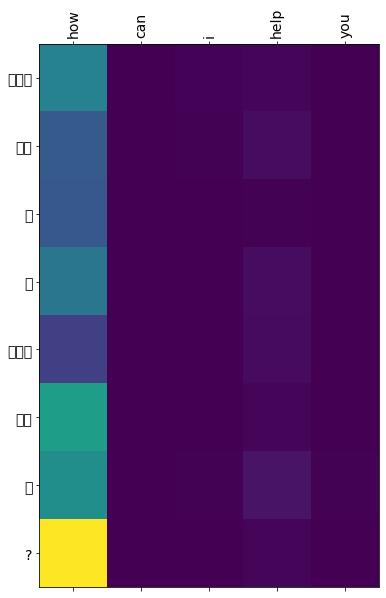

In [113]:
translate('how can I help you')

## BLEU Score (Bilingual Evaluation Understudy Score)
기계 번역의 성능이 얼마나 뛰어난가를 측정하기 위해 사용되는 대표적인 방법 중 하나인 BLEU(Bilingual Evaluation Understudy)를 측정해봅시다. 
- 논문 : BLEU: a Method for Automatic Evaluation of Machine Translation
- BLEU 점수는 기계 번역된 텍스트와 고품질 참조 번역 세트의 유사성을 측정하는 0과 1 사이의 숫자입니다. 
    - 값이 0이면 기계 번역된 출력이 참조 번역과 겹치는 부분이 없는 것을 의미하고(저품질)
    - 1이면 참조 번역과 완벽하게 겹치는 것을 의미합니다(고품질)

- BLEU 설명 
    - https://jrc-park.tistory.com/273
    - https://wikidocs.net/31695
    - https://cloud.google.com/translate/automl/docs/evaluate?hl=ko#bleu

In [114]:
import numpy as np
from collections import Counter
from nltk import ngrams

BLEU는 기계 번역 결과와 사람이 직접 번역한 결과가 얼마나 유사한지 비교하여 번역에 대한 성능을 측정하는 방법입니다. 

In [115]:
import nltk.translate.bleu_score as bleu

candidate = 'It is a guide to action which ensures that the military always obeys the commands of the party'
references = [
    'It is a guide to action that ensures that the military will forever heed Party commands',
    'It is the guiding principle which guarantees the military forces always being under the command of the Party',
    'It is the practical guide for the army always to heed the directions of the party'
]

print('패키지 NLTK의 BLEU :',bleu.sentence_bleu(list(map(lambda ref: ref.split(), references)),candidate.split()))

패키지 NLTK의 BLEU : 0.5045666840058485


In [116]:
ref_train = [seq_to_tar(sen) for sen in decoder_input_train[:100]]

In [117]:
pred_train = []
for idx in tqdm(range(len(encoder_input_train[:100]))):
    pred_train.append(decode_sequence(encoder_input_train[idx:idx+1]))

  0%|          | 0/100 [00:00<?, ?it/s]

In [118]:
bleu_score = 0
for ref, pred in zip(ref_train, pred_train):
    if len(ref) == 0 or len(pred) == 0:
        continue
    bleu_score += bleu.sentence_bleu(ref, pred)

bleu_score = bleu_score/len(ref_train)
bleu_score

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.7574944638219547

In [119]:
ref_test = [seq_to_tar(sen) for sen in decoder_input_test[:100]]
pred_test = [decode_sequence(encoder_input_test[idx:idx+1]) for idx in tqdm(range(len(encoder_input_test[:100])))]

bleu_score = 0
for ref, pred in zip(ref_test, pred_test):
    if len(ref) == 0 or len(pred) == 0:
        continue
    bleu_score += bleu.sentence_bleu(ref, pred)

bleu_score = bleu_score/len(ref_test)
bleu_score

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.7082902469240908

### Reference

- https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html
- https://wikidocs.net/86900